# Les optimisation en ordonnancement.

# Introduction.

Dans ce notebook, je vais principalement traiter des problèmes d'ordonnancement en usine et en atelier.

Les principaux modèles sont ( En Anglais ) :

- <b>Machine unique</b> ( Single machine sheduling/bottleneck )
- <b>Machines parallèles</b> 
- <b>Ateliers à cheminement unique</b> (Flow Shop)
- <b>Ateliers à cheminements multiples</b> (Job Shop)

Je vais résoudre avec divers solveurs Python.

La planification optimale des tâches (Jobs en Anglais) est une classe de problèmes d'optimisation liés à la planification. Les entrées de ces problèmes sont une liste de tâches (également appelées processus ou tâches) et une liste de machines (également appelées processeurs ou travailleurs). La sortie requise est un calendrier - une affectation de tâches aux machines. Le calendrier doit optimiser une certaine fonction objectif.
Les machines peuvent avoir un temps de préparation (set up time) entre chaque traitement de tâche.

On peut transposer les modèles mathématiques à d'autres cas d'utilisation, on peut trouver les optimisations de type "gestion de projet" dans mon fichier 7, c'est également de l'ordonnancement.

Etude globale proposée par <b>Estelle Derrien - Github estellederrien</b>

*** CREATION EN COURS /  SUJET A MODIFICATIONS ***


# Sommaire

- Intro. <b> Récapitulatif graphique des problèmes</b>
- 1. <b>Machine unique</b>
        - Les Techniques d'ordonnancement
        - A. Notre problème de base
             - Description
             - Solution avec IterTools
             - Solution et exemples avec Python Pyomo
        - B. Minimiser les retards totaux avec l'algorithme Moore and Hogson. (Minimize tardiness sum)
             - Description
             - Modélisation mathématique
             - Solution avec les solveurs
        - C. Prendre en compte les priorités/Poids/Profit.
             - Description
             - Modélisation mathématique
             - Solution avec les solveurs
- 2. <b>Machines parrallèles</b>
        - Notre problème de base
        - Modélisation mathématique
        - Résolution
- 3. <b>Ateliers à cheminement unique (Flow Shop)</b>
        - Notre problème de base
        - Modélisation mathématique
        - Résolution avec Python Pulp
- 4. <b>Ateliers à cheminements multiples (Job Shop)</b>
        - Notre problème de base
        - Modélisation mathématique
        - Exemple


# Intro. Récapitulatif graphique des problèmes .

- Le problème de machine unique:

<div style="text-align:center">
<img src="img/ordonnancement/Machine_unique_Ordonnant.JPEG">
</div>

- Le problème de machines parallèles:

<div style="text-align:center">
<img src="img/ordonnancement/Machine_Parallèles_Ordonnancement.JPEG">
</div>

- L'atelier à cheminement unique ( Flow shop):

<div style="text-align:center">
<img src="img/ordonnancement/Flow_Shop_Ordonnancement.JPEG">
</div>

- Ateliers à cheminements multiples (Job Shop):

<div style="text-align:center">
<img src="img/ordonnancement/Job_Shop_Ordonnancement.JPEG">
</div>







# 1. Ordonnancement de Machine unique 

<b> Techniques d'ordonnancement basiques de machine unique.</b>

<b>Avant d'aborder les techniques d'optimisation linéaires</b>, il existe déjà des techniques de base s'appliquant aux travaux/jobs, qu'on peut appliquer :

- FCFS : Premier arrivé , premier servi

- SPT : On traite d'abord les travaux qui ont le temps de processus le plus court(Shortest Processing time)

- EDD : On traite d'abord les travaux qui ont la date due la plus courte (Earliest due date).

Regarder cette très bonne vidéo pour comprendre et adopter le vocabulaire approprié : 
https://www.youtube.com/watch?v=KnlBtvyU8sM

<b>Maintenant, Les calculs à faire en optimisation :</b>

Là, c'est différent, on utilise des algorithmes plus complexes et parfois les solveurs.
On cherche à minimiser les retards dans la livraison des travaux (tardiness) ou le temps de complétion, on peut aussi prendre en compte la priorité des travaux/jobs ou même le profit engendré par tel ou tel job pour minimiser le temps de complétion.






## A. Notre problème de base.

- J'ai 1 machine, 3 travaux à réaliser dessus. 
- Les travaux ont une durée respective de 2,5 et 6 heures 
- Les travaux doivent être délivrés à 15H, 9H et 11 heures respectivement.
Comment ne pas avoir de retard ?

<div style="text-align:center">
<img src="img/single-machine-scheduling.png">
</div>

La machine:

    - Ne peut pas effectuer plus d'une tâche à la fois. (Pas de multi-tâches)
    - Pourrait avoir un temps de configuration avant de commencer à effectuer une tâche.
    - Traite un travail après l'autre immédiatement.

Les tâches:

    - Ont un temps de traitement spécifique.
    - Facultatif : Avoir une priorité spécifique (poids,coût,profit...).


Voici ce que l'on obtient en essayant à la main :

<div style="text-align:center">
<img src="img/single_machine_scheduling.jpg">
</div>


# Solution avec IterTools

Pour ce problème, on utilise la fonction de permutations de itertools. ( crédit : Tim Roberts - StackOverflow).
"On a pas besoin d'un solveur car il n'y a pas de paramètre à minimiser."

En effet, on voit que les tâches sont désormais bien dans l'ordre qu'on a déduit manuellement à la phase précédente !



In [113]:

import itertools

taches = [("tache1", 2, 15), ("tache2", 5, 9), ("tache3", 6,11)]

# For each permutation
for tasklist in itertools.permutations(taches):
    time = 1
    start = []
    order = []
    for task in tasklist:
        start.append( time )
        order.append( task )
        time += task[1]
        if time-1 > task[2]:
            # We violated a due date constraint.
            break
    else:
        print("Ordre à appliquer",order,"succes")


Ordre à appliquer [('tache2', 5, 9), ('tache3', 6, 11), ('tache1', 2, 15)] succes


# Solution et exemples avec Pyomo

Cet excellent document permet d'aborder l'ordonnancement de machine unique, avec même les exemples FIFO, Early date due etc... Ce sont les techniques les plus simples avant l'optimisation en elle même.

URL : 
https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/docs/04.02-Machine-Bottleneck.ipynb#scrollTo=ziXXmrrlplII


Un gantt des jobs en attente non encore optimisé :

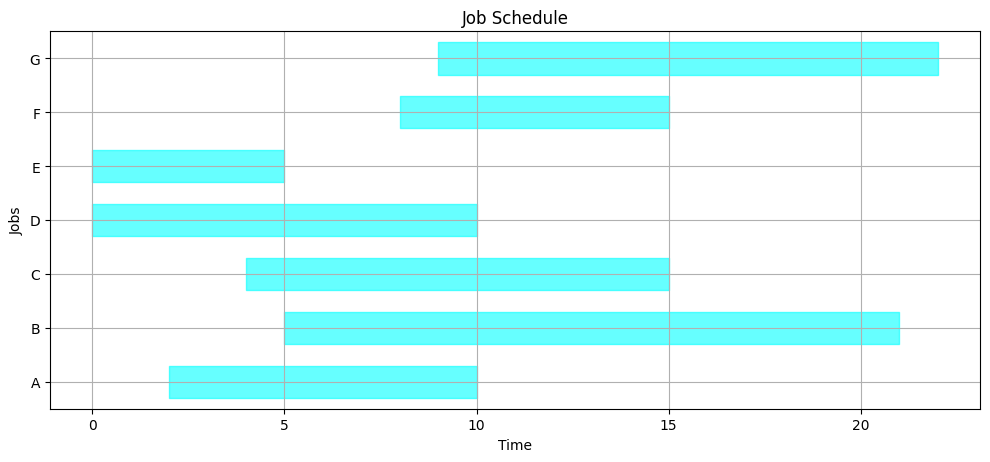

In [114]:
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import shutil
import sys
import os.path

JOBS = {
    'A': {'release': 2, 'duration': 5, 'due': 10},
    'B': {'release': 5, 'duration': 6, 'due': 21},
    'C': {'release': 4, 'duration': 8, 'due': 15},
    'D': {'release': 0, 'duration': 4, 'due': 10},
    'E': {'release': 0, 'duration': 2, 'due':  5},
    'F': {'release': 8, 'duration': 3, 'due': 15},
    'G': {'release': 9, 'duration': 2, 'due': 22},
}

def gantt(JOBS, SCHEDULE={}):
    bw = 0.3
    plt.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    plt.ylim(-0.5, idx-0.5)
    plt.title('Job Schedule')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.yticks(range(len(JOBS)), JOBS.keys())
    plt.grid()
    xlim = plt.xlim()
    
    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        plt.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        plt.xlim(xlim)
        plt.ylim(-0.5, len(MACHINES)-0.5)
        plt.title('Machine Schedule')
        plt.yticks(range(len(MACHINES)), MACHINES)
        plt.ylabel('Machines')
        plt.grid()

gantt(JOBS)

## Un premier essai d'ordonnancement

Un planning consiste en un dictionnaire répertoriant les heures de début et de fin de chaque tâche. Une fois l'ordre des tâches déterminé, l'heure de début ne peut pas être antérieure au moment où la tâche est libérée pour traitement, ni avant la fin de la tâche précédente.

La cellule suivante présente une fonction qui, à partir des données JOBS et d'une liste d'index de tâches, calcule les heures de début et de fin de toutes les tâches sur une seule machine. 


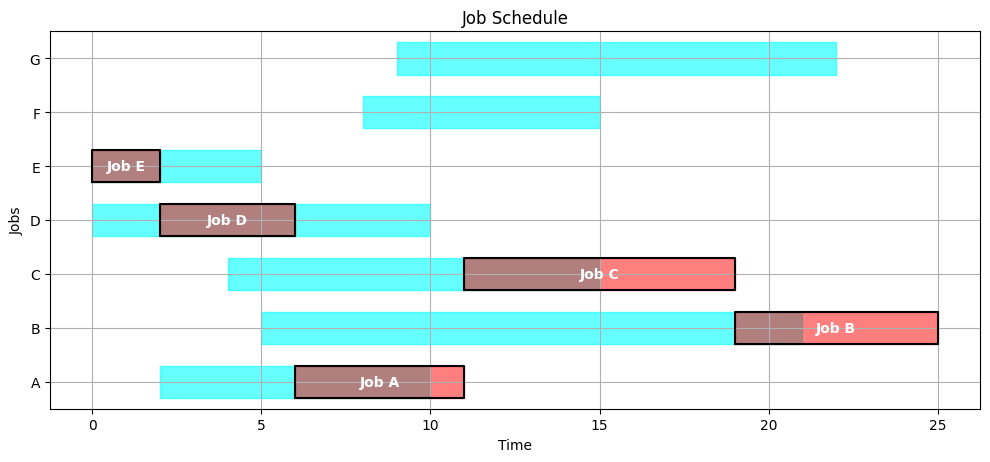

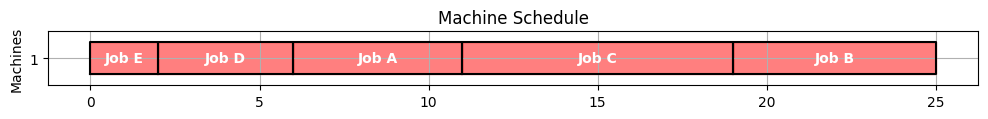

In [115]:
def schedule(JOBS, order=sorted(JOBS.keys())):
    """Schedule a dictionary of JOBS on a single machine in a specified order."""
    start = 0
    finish = 0
    SCHEDULE = {}
    for job in order:
        start = max(JOBS[job]['release'], finish)
        finish = start + JOBS[job]['duration']
        SCHEDULE[job] = {'start': start, 'finish': finish}
    return SCHEDULE   

SCHEDULE = schedule(JOBS)
SCHEDULE

gantt(JOBS, schedule(JOBS, ['E', 'D', 'A', 'C', 'B']))

## Dans l'ordre Alphabétique

Ici, on trie les tâches par ordre alphabétique ... On ne respecte  pas les dates dues.

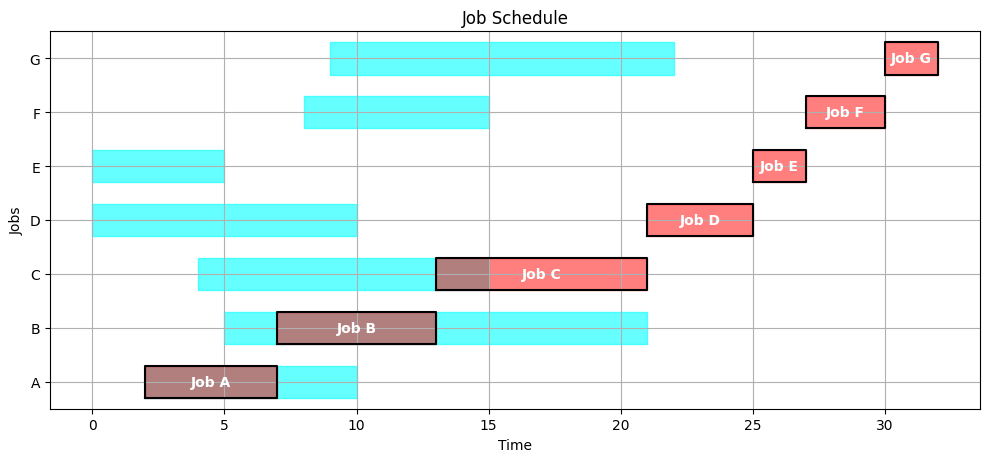

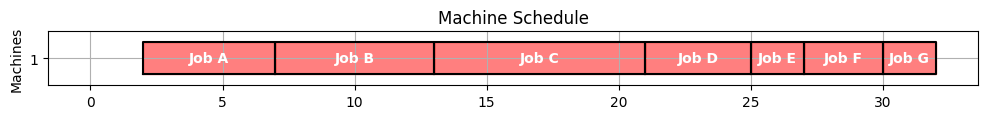

In [116]:
gantt(JOBS, SCHEDULE)

## Les indicateurs de performance.

une fonction qui donne les indicateurs de performance

In [117]:
def kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

kpi(JOBS, SCHEDULE)

{'Makespan': 32,
 'Max Pastdue': 22,
 'Sum of Pastdue': 68,
 'Number Pastdue': 5,
 'Number on Time': 2,
 'Fraction on Time': 0.2857142857142857}

## Un exemple d'ordonnancement en FIFO

Premier arrivé , premier servi

{'Makespan': 30,
 'Max Pastdue': 13,
 'Sum of Pastdue': 31,
 'Number Pastdue': 6,
 'Number on Time': 1,
 'Fraction on Time': 0.14285714285714285}

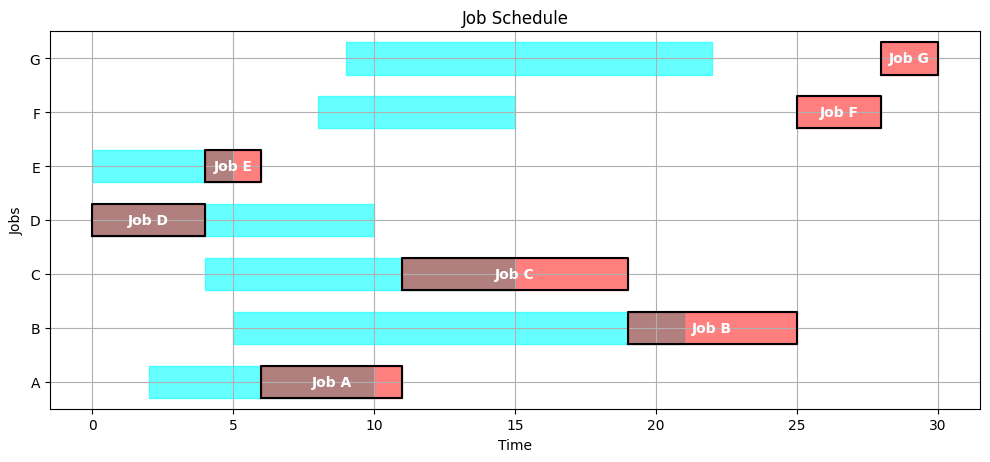

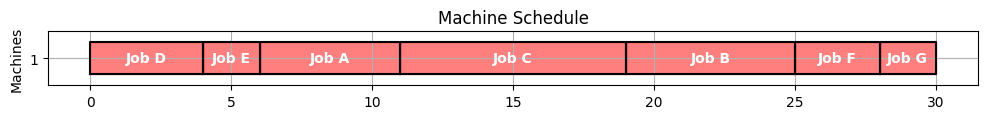

In [118]:
def fifo(JOBS):
    order_by_release = sorted(JOBS, key=lambda job: JOBS[job]['release'])
    return schedule(JOBS, order_by_release)

SCHEDULE = fifo(JOBS)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

## Un ordonnancement par date au plus court

On choisit en priorité les jobs qui ont la date due la plus urgente

{'Makespan': 30,
 'Max Pastdue': 8,
 'Sum of Pastdue': 27,
 'Number Pastdue': 5,
 'Number on Time': 2,
 'Fraction on Time': 0.2857142857142857}

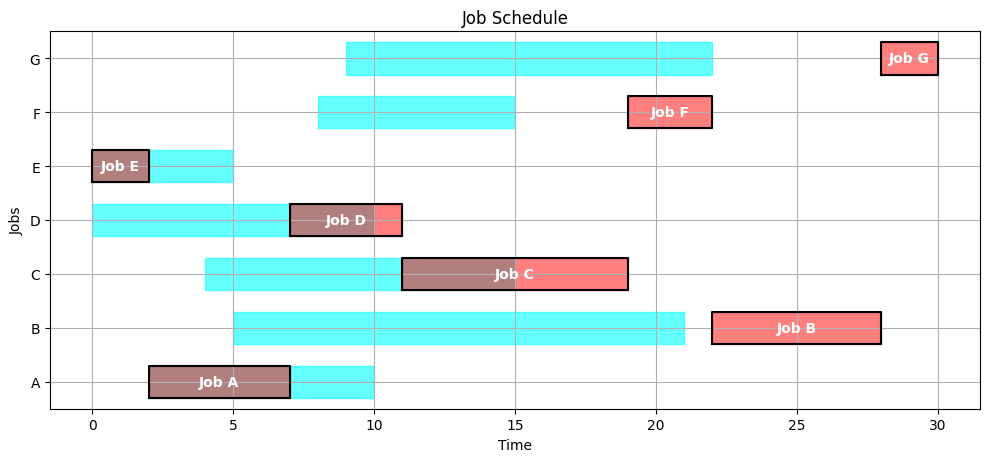

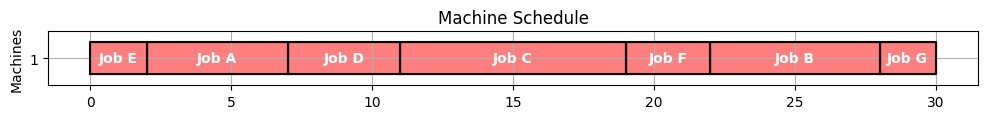

In [119]:
def edd(JOBS):
    unfinished_jobs = set(JOBS.keys())
    start = 0
    while len(unfinished_jobs) > 0:
        start = max(start, min(JOBS[job]['release'] for job in unfinished_jobs))
        edd = {job:JOBS[job]['due'] for job in unfinished_jobs if JOBS[job]['release'] <= start}
        job = min(edd, key=edd.get)
        finish = start + JOBS[job]['duration']
        unfinished_jobs.remove(job)
        SCHEDULE[job] = {'machine': 1, 'start': start, 'finish': finish}
        start = finish
    return SCHEDULE          
    
gantt(JOBS, edd(JOBS))
kpi(JOBS, edd(JOBS))

In [120]:


from pyomo.environ import *
from IPython.display import display
import pandas as pd
from pyomo.opt import SolverFactory
import sys
import pyomo.environ as pyo


# On configure le chemin du solveur non linéaire sous windows.
solvername='ipopt'
solverpath_folder='C:\\ipopt' #does not need to be directly on c drive
solverpath_exe='C:\\ipopt\\bin\\ipopt' #does not need to be directly on c drive
sys.path.append(solverpath_folder)

def schedule(JOBS):
    
    # create model
    m = ConcreteModel()
    
    # index set to simplify notation
    J = list(JOBS.keys())

    # decision variables
    m.start      = Var(J, domain=NonNegativeReals)
    m.makespan   = Var(domain=NonNegativeReals)
    m.pastdue    = Var(J, domain=NonNegativeReals)
    m.early      = Var(J, domain=NonNegativeReals)
    
    # additional decision variables for use in the objecive
    m.ispastdue  = Var(J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)

    # for modeling disjunctive constraints
    m.y = Var(J, J, domain=Binary)
    BigM = 1000  #  max([JOBS[j]['release'] for j in J]) + sum([JOBS[j]['duration'] for j in J])

    m.OBJ = Objective(
        expr = sum([m.pastdue[j] for j in J]),
        sense = minimize
    )

    m.cons = ConstraintList()
    for j in J:
        m.cons.add(m.start[j] >= JOBS[j]['release'])
        m.cons.add(m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
        m.cons.add(m.pastdue[j] <= m.maxpastdue)
        m.cons.add(m.start[j] + JOBS[j]['duration'] <= m.makespan)
        m.cons.add(m.pastdue[j] <= BigM*m.ispastdue[j])
        for k in J:
            if j < k:
                m.cons.add(m.start[j] + JOBS[j]['duration'] <= m.start[k] + BigM*(1-m.y[j,k]))
                m.cons.add(m.start[k] + JOBS[k]['duration'] <= m.start[j] + BigM*(m.y[j,k]))
    
#SolverFactory('glpk').solve(m)
results = pyo.SolverFactory(solvername,executable=solverpath_exe).solve(m)

# On affiche les résultats.
# print("item=", pyo.value(model.item))
# print("objective=", pyo.value(model.OBJ))
print(results)

for j in J:
    JOBS[j]['start'] = m.start[j]()
    JOBS[j]['finish'] = m.start[j]() + JOBS[j]['duration']
    JOBS[j]['pastdue'] = m.pastdue[j]()
    JOBS[j]['early'] = m.early[j]()
    JOBS[j]['ispastdue'] = m.ispastdue[j]()
        
    # display table of results
    df = pd.DataFrame(JOBS)
    df['Total'] = df.sum(axis=1)
    df.loc[['due','finish','release','start'],'Total'] = ''
    display(df)
        
    return JOBS

JOBS = schedule(JOBS)

AttributeError: 'LpProblem' object has no attribute 'valid_problem_types'

# B. Minimiser les retards totaux avec l'algorithme Moore and Hogson.

# Description :

L'algorithme de Moore-Hodgson est une approche de la planification du travail qui vise à minimiser le nombre de tâches en retard, plutôt que le retard d'une tâche particulière.

Soit un ensemble de jobs S, leur durées Sd et leurs dates dues Sd , Cet algo planifie de façon à délivrer une solution sans aucun job en retard, même si pour cela il doit <b>éliminer</b> certains jobs.

Source:
https://page.mi.fu-berlin.de/rote/Papers/pdf/A+parallel+scheduling+algorithm+for+minimizing+the+number+of+unscheduled+jobs.pdf

Le code est encore à trouver/réaliser.

# C. Prendre en compte les Poids/Profit.

## Description.
Cette fois ci, on accorde à chaque job un poids ou un profit spécifique, et cela rentre en compte dans l'optimisation.

# Modélisation mathématique

Réalisation en cours, pas encore bon !

- Soit R une machine
- Soit T un ensemble de tâches (T1,T2,T3...Tn)
- Soit Dt la durée d'une tâche
- Soit Et l'heure due d'une tâche
- Soit CMt l'heure de commencement d'une tâche

Les variables de décisions sont: 
Xit début de la tâche t ∈ T sur la machine R

Il faut minimiser la somme des retards des tâches.

Hypothèse : 
- Soit l'ensemble K des possibilités de début de tâche qui sont des variables de décision

Programme linéaire (encours, faux!):

- Min Σ T * Dt
- Sous les contraintes
- Σ Ct >= Et

# Résolution avec Pulp

Le code n'aura pas de boucles For pour mieux comprendre.

Code faux - résolution en cours !!

In [ ]:
import pulp as p

# Tasks
tasks = ["task1","task2"]
duration = {1,3}
due = {1,4}
starts = {1,2,3,4}

# Create problem
prob = p.LpProblem('single_machine_scheduling', p.LpMinimize)  

# Each possible "time slots" to select for tasks
task1_1 = p.LpVariable("task1_1", 0, None, p.LpBinary) 
task1_2 = p.LpVariable("task1_2", 0, None, p.LpBinary) 
task1_3 = p.LpVariable("task1_3", 0, None, p.LpBinary) 
task1_4 = p.LpVariable("task1_4", 0, None, p.LpBinary) 
task2_1 = p.LpVariable("task2_1", 0, None, p.LpBinary) 
task2_2 = p.LpVariable("task2_2", 0, None, p.LpBinary) 
task2_3 = p.LpVariable("task2_3", 0, None, p.LpBinary)  
task2_4 = p.LpVariable("task2_4", 0, None, p.LpBinary) 

# Theses constraints should be used for due dates constraints eventually...
start_1 = p.LpVariable("start_1", 0, None, p.LpContinuous) 
start_2 = p.LpVariable("start_2", 0, None, p.LpContinuous) 
start_3 = p.LpVariable("start_3", 0, None, p.LpContinuous) 
start_4 = p.LpVariable("start_4", 0, None, p.LpContinuous) 


# Objective : Minimize timespan
prob += 1 * task1_1 + 1 * task1_2 + 1 * task1_3 + 1 * task1_4 + 3 * task2_1 + 3 * task2_2 + 3 * task2_3 + 3 * task2_4

# Constraints

# Only one task1 and one task2 can be selected
prob +=  task1_1 + task1_2 + task1_3 + task1_4 == 1
prob +=  task2_1 + task2_2 + task2_3 + task2_4 == 1

# Due dates constraints ( How to ?)

# Solve
prob.solve()

# Print variables
for v in prob.variables():
    print(v.name, "=", v.varValue)
# Print objective
print("Minimized  = ", p.value(prob.objective))




task1_1 = 0.0
task1_2 = 0.0
task1_3 = 0.0
task1_4 = 1.0
task2_1 = 0.0
task2_2 = 0.0
task2_3 = 0.0
task2_4 = 1.0
Minimized  =  4.0


# Code fonctionnel avec poids

On teste le code de KeivanTafakkori.

In [ ]:
import pulp as op
import itertools as it

#Developer: @KeivanTafakkori, 8 March 2022

def model(I,J,p,s,dispmodel="y",solve="y", dispresult="y"):
    print(J)
    m = op.LpProblem("SingleMachineSchedulingProblem", op.LpMinimize)
    x = {(i,j): op.LpVariable(f"x{i}{j}", 0,1, op.LpBinary) for i,j in it.product(I, J)}

    c = {j: op.LpVariable(f"c{j}", 0, None, op.LpContinuous) for j in J}
    objs = {0: sum(w[j]*c[j] for j in J)} 
    cons = {0: {i: (sum(x[(i,j)] for j in J) == 1, f"eq1_{i}") for i in I},
            1: {j: (sum(x[(i,j)] for i in I) == 1, f"eq2_{j}") for j in J},
            2: {j: (c[j] >= c[j-1] + sum(x[(i,j)]*p[i] for i in I), f"eq3_{j}") for j in J if j!=0},
            3: {0: (c[0] == s + sum(x[(i,0)]*p[i] for i in I), "eq4_")}}
    m += objs[0]
    for keys1 in cons: 
        for keys2 in cons[keys1]: m += cons[keys1][keys2]
        if dispmodel=="y":
            print("Model --- \n",) # add m
        if solve == "y":
            result = m.solve(op.PULP_CBC_CMD(timeLimit=None))
            print("Status --- \n", op.LpStatus[result])
            if dispresult == "y" and op.LpStatus[result] =='Optimal':
                print("Objective --- \n", op.value(m.objective))
                print("Decision --- \n", [(variables.name,variables.varValue) for variables in m.variables() if variables.varValue!=0])
    return m, c, x

w = [0.1, 0.4, 0.15, 0.35] #Priority weight of each job
p = [  7,   3,    9,    4] #Processing time of each job
s = 5 #Setup time of the machine
I = range(len(p)) #Set of jobs
J = range(len(I)) #Set of positions


m, c, x = model(I,J,p,s) #Model and solve the problem

range(0, 4)
Model --- 

Status --- 
 Optimal
Objective --- 
 0.0
Decision --- 
 [('x03', 1.0), ('x13', 1.0), ('x23', 1.0), ('x33', 1.0)]
Model --- 

Status --- 
 Optimal
Objective --- 
 0.0
Decision --- 
 [('x01', 1.0), ('x12', 1.0), ('x23', 1.0), ('x30', 1.0)]
Model --- 

Status --- 
 Optimal
Objective --- 
 7.1499999999999995
Decision --- 
 [('c1', 3.0), ('c2', 7.0), ('c3', 14.0), ('x03', 1.0), ('x11', 1.0), ('x20', 1.0), ('x32', 1.0)]
Model --- 

Status --- 
 Optimal
Objective --- 
 18.25
Decision --- 
 [('c0', 8.0), ('c1', 12.0), ('c2', 19.0), ('c3', 28.0), ('x02', 1.0), ('x10', 1.0), ('x23', 1.0), ('x31', 1.0)]


# 2. Machines Parrallèles 

# Description

Source :  or Tools 
https://developers.google.com/optimization/scheduling/job_shop?hl=fr

L'atelier, dans lequel plusieurs tâches sont traitées sur plusieurs machines, est un problème courant de planification.

Chaque tâche consiste en une séquence de tâches, qui doivent être exécutées dans un ordre donné, et chaque tâche doit être traitée sur une machine spécifique. Par exemple, la tâche peut consister à fabriquer un seul article grand public, comme une automobile. Le problème consiste à planifier les tâches sur les machines de manière à minimiser le length de la planification, c'est-à-dire le temps nécessaire à l'exécution de toutes les tâches.

Il existe plusieurs contraintes pour ce problème:

    Aucune tâche d'une tâche ne peut être lancée tant que la tâche précédente n'est pas terminée.
    Une machine ne peut travailler que sur une tâche à la fois.
    Une fois lancée, une tâche doit s'exécuter jusqu'à la fin.

<div style="text-align:center">
<img src="img/ordonnancement/Machine_Parallèles_Ordonnancement.JPEG">
</div>


## Code avec Or Tools

In [ ]:
"""Minimal jobshop example."""
import collections
from ortools.sat.python import cp_model


def main():
    """Minimal jobshop problem."""
    # Data.
    jobs_data = [  # task = (machine_id, processing_time).
        [(0, 3), (1, 2), (2, 2)],  # Job0
        [(0, 2), (2, 1), (1, 4)],  # Job1
        [(1, 4), (2, 3)],  # Job2
    ]

    machines_count = 1 + max(task[0] for job in jobs_data for task in job)
    all_machines = range(machines_count)
    # Computes horizon dynamically as the sum of all durations.
    horizon = sum(task[1] for job in jobs_data for task in job)

    # Create the model.
    model = cp_model.CpModel()

    # Named tuple to store information about created variables.
    task_type = collections.namedtuple("task_type", "start end interval")
    # Named tuple to manipulate solution information.
    assigned_task_type = collections.namedtuple(
        "assigned_task_type", "start job index duration"
    )

    # Creates job intervals and add to the corresponding machine lists.
    all_tasks = {}
    machine_to_intervals = collections.defaultdict(list)

    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine, duration = task
            suffix = f"_{job_id}_{task_id}"
            start_var = model.NewIntVar(0, horizon, "start" + suffix)
            end_var = model.NewIntVar(0, horizon, "end" + suffix)
            interval_var = model.NewIntervalVar(
                start_var, duration, end_var, "interval" + suffix
            )
            all_tasks[job_id, task_id] = task_type(
                start=start_var, end=end_var, interval=interval_var
            )
            machine_to_intervals[machine].append(interval_var)

    # Create and add disjunctive constraints.
    for machine in all_machines:
        model.AddNoOverlap(machine_to_intervals[machine])

    # Precedences inside a job.
    for job_id, job in enumerate(jobs_data):
        for task_id in range(len(job) - 1):
            model.Add(
                all_tasks[job_id, task_id + 1].start >= all_tasks[job_id, task_id].end
            )

    # Makespan objective.
    obj_var = model.NewIntVar(0, horizon, "makespan")
    model.AddMaxEquality(
        obj_var,
        [all_tasks[job_id, len(job) - 1].end for job_id, job in enumerate(jobs_data)],
    )
    model.Minimize(obj_var)

    # Creates the solver and solve.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print("Solution:")
        # Create one list of assigned tasks per machine.
        assigned_jobs = collections.defaultdict(list)
        for job_id, job in enumerate(jobs_data):
            for task_id, task in enumerate(job):
                machine = task[0]
                assigned_jobs[machine].append(
                    assigned_task_type(
                        start=solver.Value(all_tasks[job_id, task_id].start),
                        job=job_id,
                        index=task_id,
                        duration=task[1],
                    )
                )

        # Create per machine output lines.
        output = ""
        for machine in all_machines:
            # Sort by starting time.
            assigned_jobs[machine].sort()
            sol_line_tasks = "Machine " + str(machine) + ": "
            sol_line = "           "

            for assigned_task in assigned_jobs[machine]:
                name = f"job_{assigned_task.job}_task_{assigned_task.index}"
                # Add spaces to output to align columns.
                sol_line_tasks += f"{name:15}"

                start = assigned_task.start
                duration = assigned_task.duration
                sol_tmp = f"[{start},{start + duration}]"
                # Add spaces to output to align columns.
                sol_line += f"{sol_tmp:15}"

            sol_line += "\n"
            sol_line_tasks += "\n"
            output += sol_line_tasks
            output += sol_line

        # Finally print the solution found.
        print(f"Optimal Schedule Length: {solver.ObjectiveValue()}")
        print(output)
    else:
        print("No solution found.")

    # Statistics.
    print("\nStatistics")
    print(f"  - conflicts: {solver.NumConflicts()}")
    print(f"  - branches : {solver.NumBranches()}")
    print(f"  - wall time: {solver.WallTime()}s")


if __name__ == "__main__":
    main()

Solution:
Optimal Schedule Length: 11.0
Machine 0: job_1_task_0   job_0_task_0   
           [0,2]          [2,5]          
Machine 1: job_2_task_0   job_0_task_1   job_1_task_2   
           [0,4]          [5,7]          [7,11]         
Machine 2: job_1_task_1   job_2_task_1   job_0_task_2   
           [2,3]          [4,7]          [7,9]          


Statistics
  - conflicts: 0
  - branches : 0
  - wall time: 0.009482500000000001s


## Code avec Python Mip 

https://python-mip.readthedocs.io/en/latest/examples.html

Malheureusement Gurobi qui tourne en fond est payant, donc on ne peut pas tester.

## Code avec Python Cplex